# Compute Impacts for Sudan

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from climada_petals.hazard.rf_glofas import RiverFloodInundation, save_file

/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
import re

import xarray as xr

from climada.entity import Exposures, ImpactFunc, ImpactFuncSet
from climada.engine import ImpactCalc, Impact
from climada_petals.hazard.rf_glofas import hazard_series_from_dataset


def get_worldpop_sudan(year: int) -> Exposures:
    """Return the WorldPop dataset of Sudan for a given year"""
    if year in np.arange(2008, 2020):
        exposure = Exposures.from_raster(
            f"./data/worldpop/sudan/sdn_ppp_{year}_1km_Aggregated_UNadj.tif"
        )
    else:
        exposure = Exposures.from_raster(
            f"./data/worldpop/sudan/sdn_ppp_2020_1km_Aggregated_UNadj.tif"
        )
    # exposure.set_geometry_points()
    return exposure


def impact(intensity, threshold, mdd):
    """Impacts with fixed WorldPop data"""

    def add_year(ds: xr.Dataset):
        mtch = re.search(r"sudan-(\d{4}).nc", ds.encoding["source"])
        return ds.assign_coords(time=[int(mtch.group(1))])

    with xr.open_mfdataset(
        "./data/generated/sudan/*.nc",
        chunks={},
        combine="nested",
        concat_dim="time",
        preprocess=add_year,
    ) as ds:
        hazard = hazard_series_from_dataset(ds, intensity=intensity, event_dim="time")

    hazard.frequency = np.ones_like(hazard.event_id) / hazard.size

    exposure = Exposures.from_raster(
        "./data/worldpop/sudan/sdn_ppp_2008_1km_Aggregated_UNadj.tif"
    )
    # exposure.set_geometry_points()
    exposure.gdf["impf_RF"] = 1
    exposure.assign_centroids(hazard)

    impf = ImpactFuncSet(
        [ImpactFunc.from_step_impf((0, threshold, 100), mdd=(0, mdd), haz_type="RF")]
    )

    return ImpactCalc(exposure, impf, hazard).impact(assign_centroids=False)


def impact_worldpop(intensity, threshold, mdd):
    """Impacts with varying WorldPop exposure data"""
    centr = None
    impacts = []
    for year in np.arange(2008, 2022 + 1):
        with xr.open_dataset(
            f"./data/generated/sudan/sudan-{year}.nc", chunks="auto"
        ) as ds:
            ds = ds.assign_coords(time=[year])
            hazard = hazard_series_from_dataset(
                ds, intensity=intensity, event_dim="time"
            )

        hazard.frequency = np.ones_like(hazard.event_id) / hazard.size

        exposure = get_worldpop_sudan(year)
        exposure.gdf["impf_RF"] = 1
        if centr is not None:
            exposure.gdf["centr_RF"] = centr
        else:
            exposure.assign_centroids(hazard)
        centr = exposure.gdf["centr_RF"]

        impf = ImpactFuncSet(
            [
                ImpactFunc.from_step_impf(
                    (0, threshold, 100), mdd=(0, mdd), haz_type="RF"
                )
            ]
        )
        imp = ImpactCalc(exposure, impf, hazard).impact(assign_centroids=False)
        imp.tot_value = 0
        impacts.append(imp)

    return Impact.concat(impacts, reset_event_ids=True)

In [3]:
impacts = impact_worldpop("flood_depth", threshold=1.0, mdd=1.0)
impacts_flopros = impact_worldpop("flood_depth_flopros", threshold=1.0, mdd=1.0)

2024-04-05 17:12:39,716 - climada.hazard.base - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings
2024-04-05 17:12:46,547 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-04-05 17:12:46,642 - climada.hazard.base - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings
2024-04-05 17:12:46,990 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-04-05 17:12:47,078 - climada.hazard.base - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings
2024-04-05 17:12:47,451 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exp

In [4]:
import pandas as pd

data_impacts = pd.DataFrame.from_dict(
    {
        2008: 46500,
        2009: 80000,
        2010: 20000,
        2011: 19000,
        2012: 84000,
        2013: 284000,
        2014: 187000,
        2015: 8300,
        2016: 123000,
        2017: 53800,
        2018: 121000,
        2019: 272000,
        2020: 454000,
        2021: 98330,
        2022: 103000,
    },
    orient="index",
    columns=["Disaster Internal Displacements"],
)
data_impacts

,Disaster Internal Displacements
2008,46500
2009,80000
2010,20000
2011,19000
2012,84000
2013,284000
2014,187000
2015,8300
2016,123000
2017,53800


In [5]:
data = pd.concat(
    [
        data_impacts,
        pd.DataFrame(
            {
                "Estimated": impacts.at_event,
                "Estimated FLOPROS": impacts_flopros.at_event,
            },
            index=data_impacts.index,
        ),
    ],
    axis=1,
)
data = data.rename(columns={"Disaster Internal Displacements": "IDMC"})
data

,IDMC,Estimated,Estimated FLOPROS
2008,46500,2.555869e+05,1.215479e+04
2009,80000,1.678615e+05,1.272439e+04
2010,20000,5.782952e+05,4.566151e+04
2011,19000,7.500019e+04,1.599600e+04
2012,84000,5.409496e+05,4.828882e+04
2013,284000,8.663567e+05,3.623595e+05
2014,187000,5.505583e+05,2.498463e+05
2015,8300,6.000275e+04,3.786054e+04
2016,123000,2.186211e+05,7.574296e+04
2017,53800,5.461760e+05,1.633536e+05


Text(0.5, 0, 'Year')

findfont: Font family 'LinLibertine' not found.
findfont: Font family 'LinLibertine' not found.
findfont: Font family 'LinLibertine' not found.
findfont: Font family 'LinLibertine' not found.
findfont: Font family 'LinLibertine' not found.
findfont: Font family 'LinLibertine' not found.
findfont: Font family 'LinLibertine' not found.
findfont: Font family 'LinLibertine' not found.
findfont: Font family 'LinLibertine' not found.
findfont: Font family 'LinLibertine' not found.
findfont: Font family 'LinLibertine' not found.
findfont: Font family 'LinLibertine' not found.
findfont: Font family 'LinLibertine' not found.
findfont: Font family 'LinLibertine' not found.
findfont: Font family 'LinLibertine' not found.
findfont: Font family 'LinLibertine' not found.
findfont: Font family 'LinLibertine' not found.
findfont: Font family 'LinLibertine' not found.
findfont: Font family 'LinLibertine' not found.
findfont: Font family 'LinLibertine' not found.
findfont: Font family 'LinLibertine' not

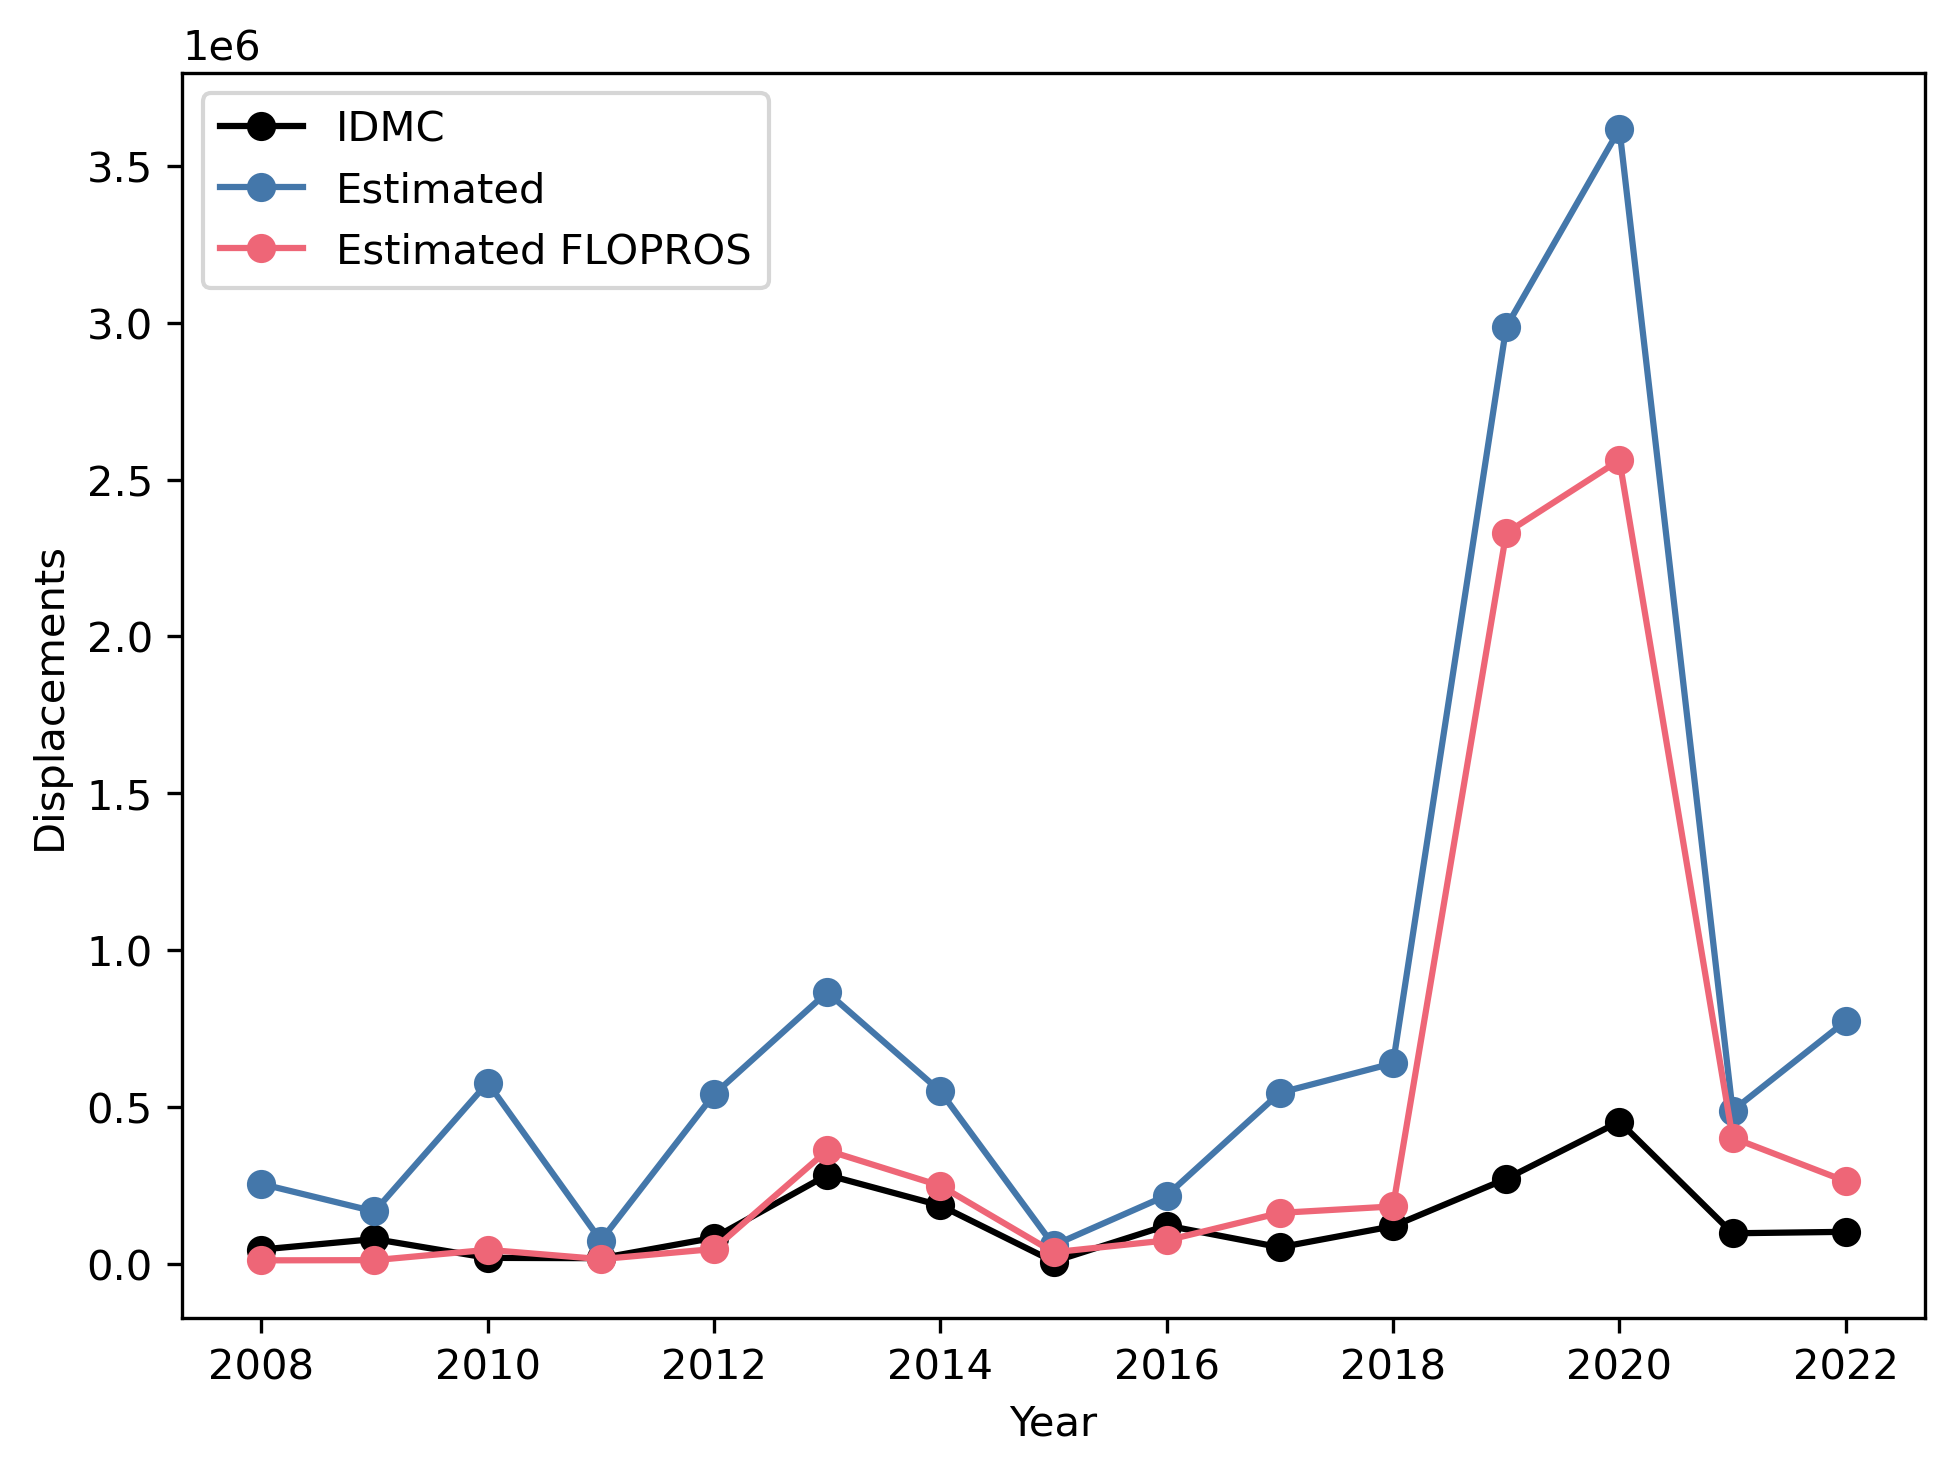

In [13]:
from cycler import cycler
import tol_colors
import matplotlib.pyplot as plt

rc = {
    "axes.titlesize": "medium",
    "axes.prop_cycle": cycler(color=tol_colors.tol_cset("bright")),
    "figure.dpi": 300,
    "figure.constrained_layout.use": True,
    # "figure.figsize": (FIG_WIDTH_TWO_COL, FIG_HEIGHT),
    "font.family": "LinLibertine",
    "font.size": 10.0,
}
plt.rcParams.update(rc)

ax = data.plot.line(color={"IDMC": "k", "Estimated": "C0", "Estimated FLOPROS": "C1"}, marker="o")
# ax.set_yscale("log")
ax.set_ylabel("Displacements")
ax.set_xlabel("Year")
# ax.set_ylim(bottom=0, top=350e3)

## Calibration Example

In [23]:
from climada.util.calibrate import BayesianOptimizer, Input, BayesianOptimizerController
from climada.util.coordinates import country_to_iso

from sklearn.metrics import mean_squared_log_error
import xarray as xr
import re

from climada.entity import Exposures, ImpactFunc, ImpactFuncSet
from climada.engine import ImpactCalc, Impact
from climada_petals.hazard.rf_glofas import hazard_series_from_dataset

def add_year(ds: xr.Dataset):
    mtch = re.search(r"sudan-(\d{4}).nc", ds.encoding["source"])
    return ds.assign_coords(time=[int(mtch.group(1))])


with xr.open_mfdataset(
    "./data/generated/sudan/*.nc",
    chunks={},
    combine="nested",
    concat_dim="time",
    preprocess=add_year,
) as ds:
    hazard = hazard_series_from_dataset(ds, intensity="flood_depth", event_dim="time")
hazard.event_id = np.arange(2008, 2022 + 1)
hazard.frequency = np.ones_like(hazard.event_id) / hazard.size

exposure = get_worldpop_sudan(2015)
exposure.gdf["impf_RF"] = 1

region_id = country_to_iso("Sudan", representation="numeric")
data = data_impacts.copy().rename(
    columns={"Disaster Internal Displacements": region_id}
)

input = Input(
    hazard=hazard,
    exposure=exposure,
    data=data,
    impact_func_creator=lambda threshold, ratio: ImpactFuncSet(
        [ImpactFunc.from_step_impf((0, threshold, 100), mdd=(0, ratio), haz_type="RF")]
    ),
    impact_to_dataframe=lambda imp: imp.impact_at_reg(
        np.full(exposure.gdf.shape[0], region_id)
    ),
    cost_func=mean_squared_log_error,
    bounds={"threshold": (0.01, 2), "ratio": (0.01, 1)},
)

opt = BayesianOptimizer(input)
controller = BayesianOptimizerController.from_input(input, sampling_base=5)
res = opt.run(controller)
res.params
params = res.params

2024-04-05 11:05:23,752 - climada.hazard.base - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings


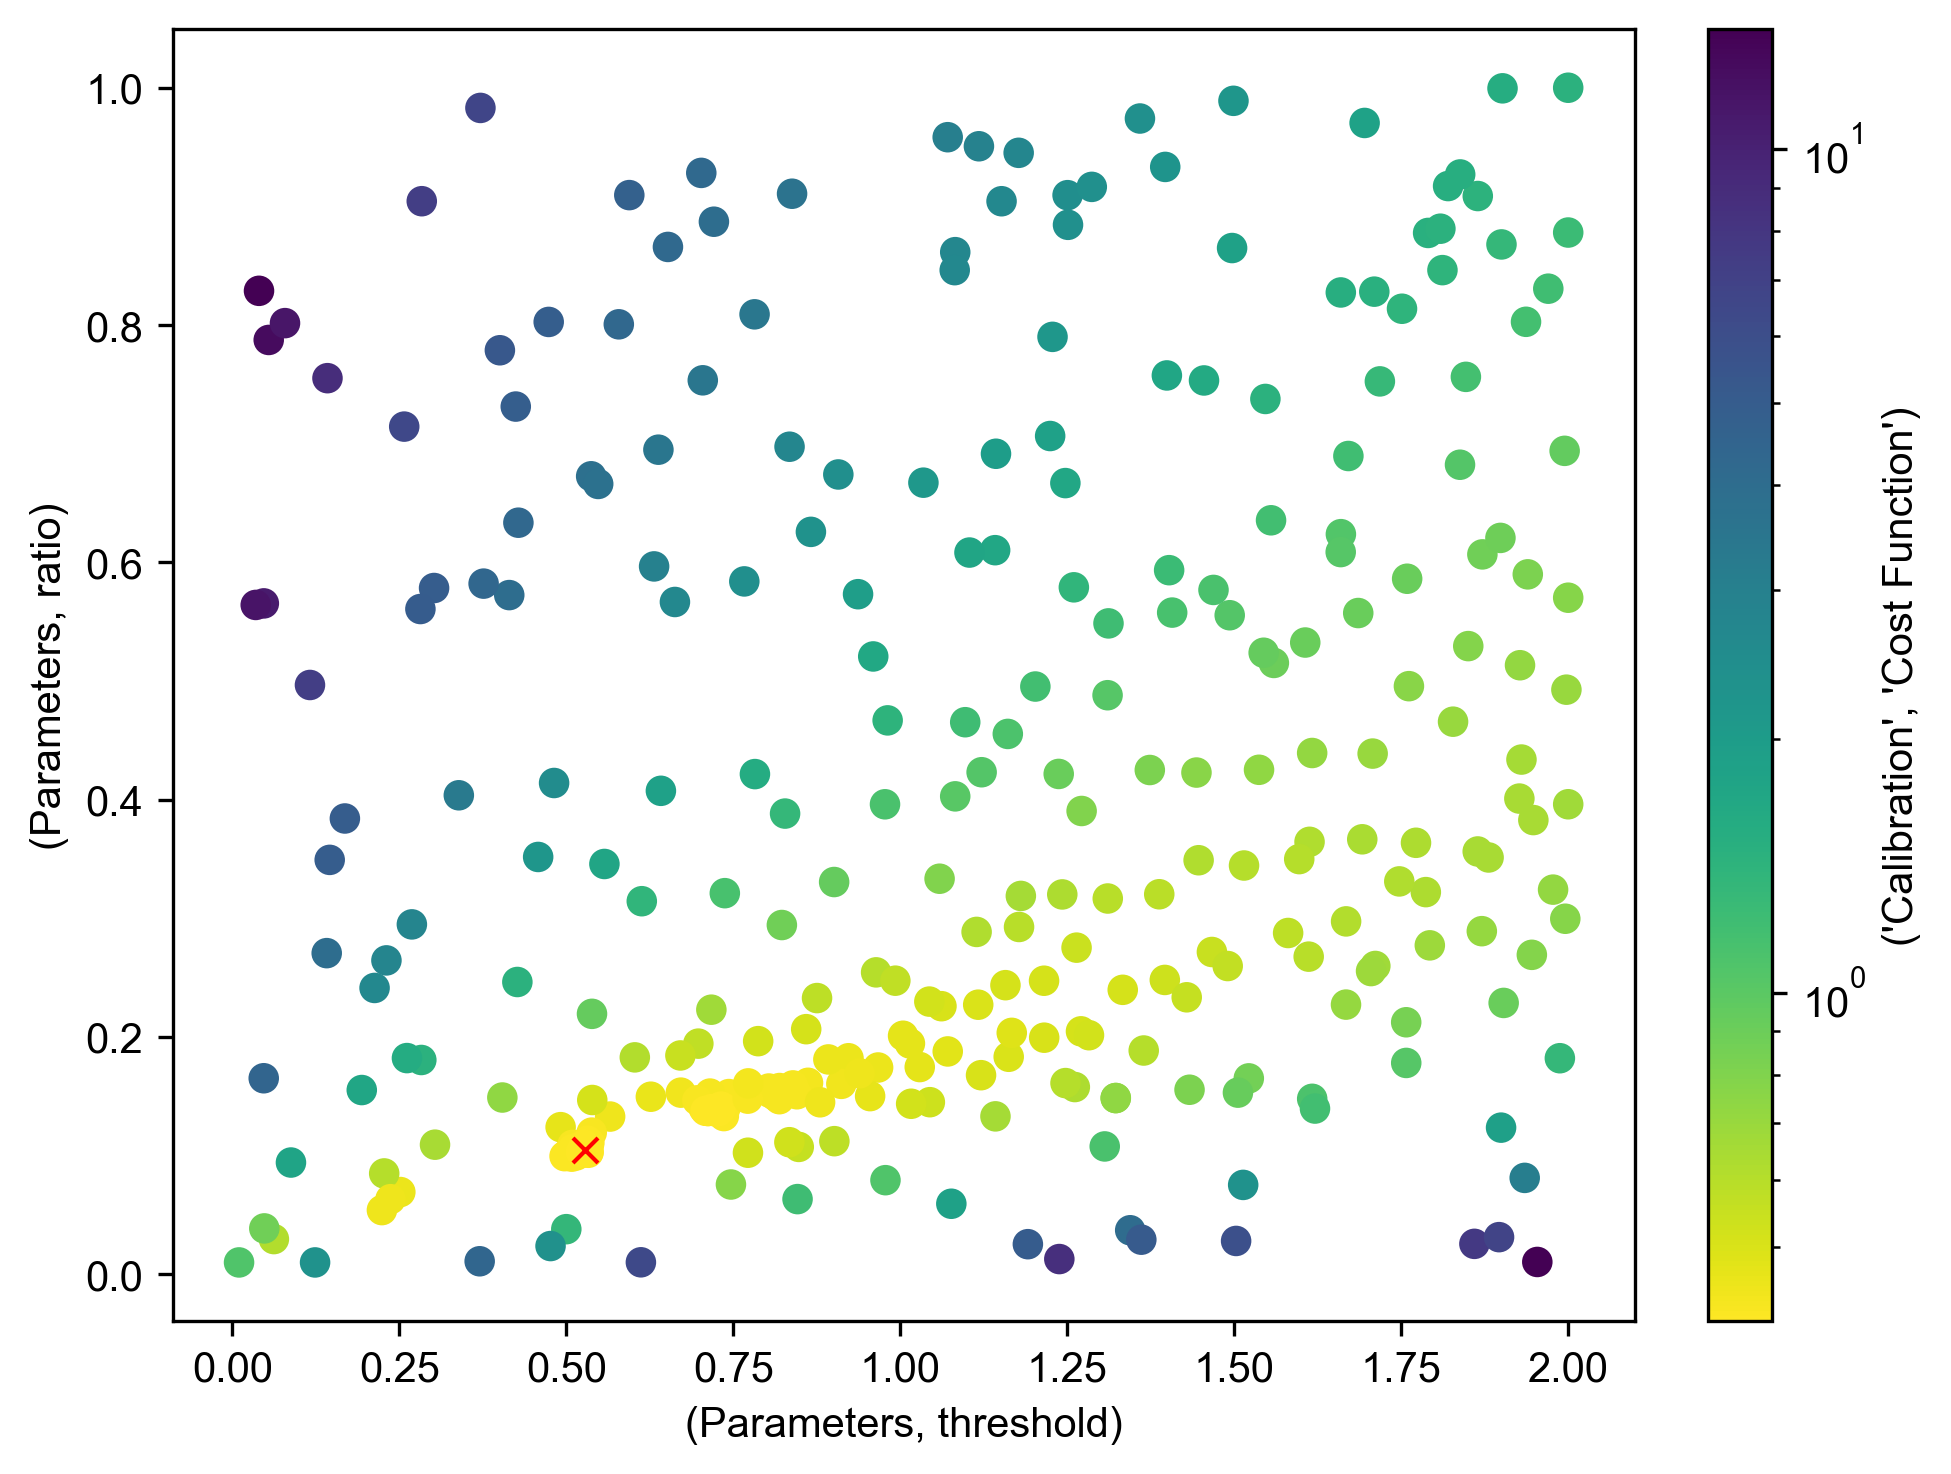

In [24]:
import matplotlib.colors as mcolors

ax = res.plot_p_space(
    x="threshold",
    y="ratio",
    norm=mcolors.LogNorm(),
)

In [25]:
from climada.util.calibrate import BayesianOptimizerOutputEvaluator

res_eval = BayesianOptimizerOutputEvaluator(input, res)

<Axes: ylabel='Impact [USD]'>

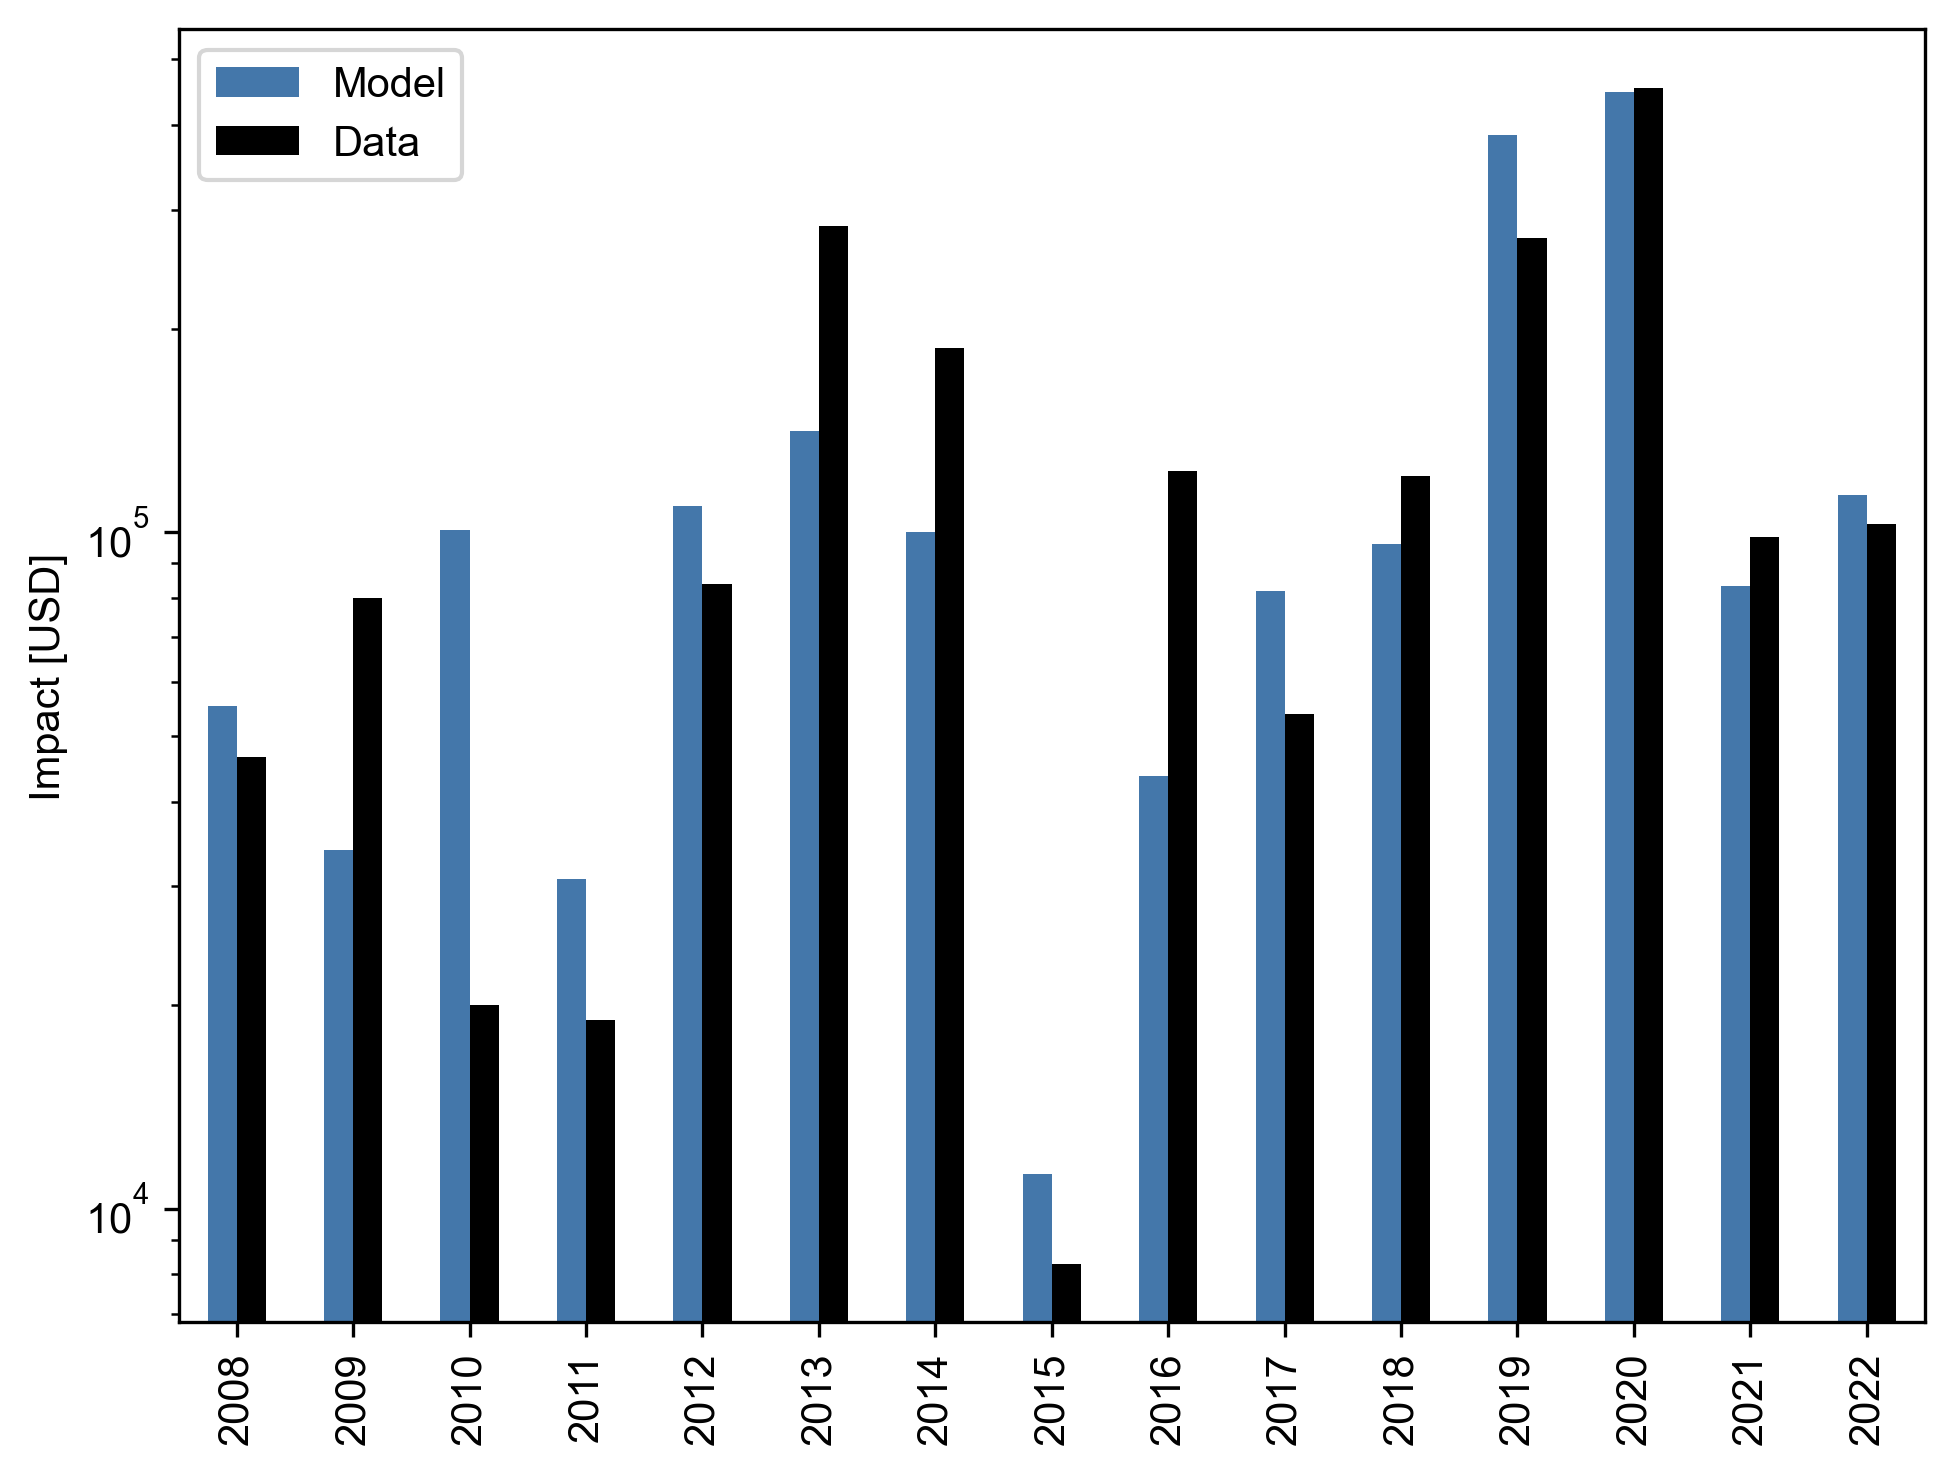

In [26]:
res_eval.plot_at_event(logy=True, color={"Data": "k", "Model": "C0"})

### With FLOPROS

In [27]:
with xr.open_mfdataset(
    "./data/generated/sudan/*.nc",
    chunks={},
    combine="nested",
    concat_dim="time",
    preprocess=add_year,
) as ds:
    hazard_flopros = hazard_series_from_dataset(
        ds, intensity="flood_depth_flopros", event_dim="time"
    )
hazard_flopros.event_id = np.arange(2008, 2022 + 1)
hazard_flopros.frequency = np.ones_like(hazard_flopros.event_id) / hazard_flopros.size

exposure = get_worldpop_sudan(2015)
exposure.gdf["impf_RF"] = 1

region_id = country_to_iso("Sudan", representation="numeric")
data_flopros = data_impacts.copy().rename(
    columns={"Disaster Internal Displacements": region_id}
)
# data_flopros.loc[[2008, 2009]] = np.nan
# data_flopros.loc[[2019, 2020]] = np.nan

input_flopros = Input(
    hazard=hazard_flopros,
    exposure=exposure,
    data=data_flopros,
    impact_func_creator=lambda threshold, ratio: ImpactFuncSet(
        [ImpactFunc.from_step_impf((0, threshold, 100), mdd=(0, ratio), haz_type="RF")]
    ),
    impact_to_dataframe=lambda imp: imp.impact_at_reg(
        np.full(exposure.gdf.shape[0], region_id)
    ),
    cost_func=mean_squared_log_error,
    bounds={"threshold": (0.01, 2), "ratio": (0.01, 1)},
)

opt = BayesianOptimizer(input_flopros)
controller = BayesianOptimizerController.from_input(input_flopros, sampling_base=5)
res_flopros = opt.run(controller)
res_flopros.params

2024-04-05 11:09:06,155 - climada.hazard.base - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings


{'ratio': 0.789652087642357, 'threshold': 1.4304110863842558}

In [28]:
controller.improvements()

,iteration,random,target,improvement
sample,,,,
0,0,True,-1.487623,inf
4,0,True,-1.388212,0.071611
8,0,True,-1.354526,0.024869
10,0,True,-1.171172,0.156556
12,0,True,-1.112625,0.052620
29,0,False,-1.088031,0.022604
32,0,False,-1.080249,0.007204
99,1,False,-1.078438,0.001679
148,2,False,-1.075101,0.003105


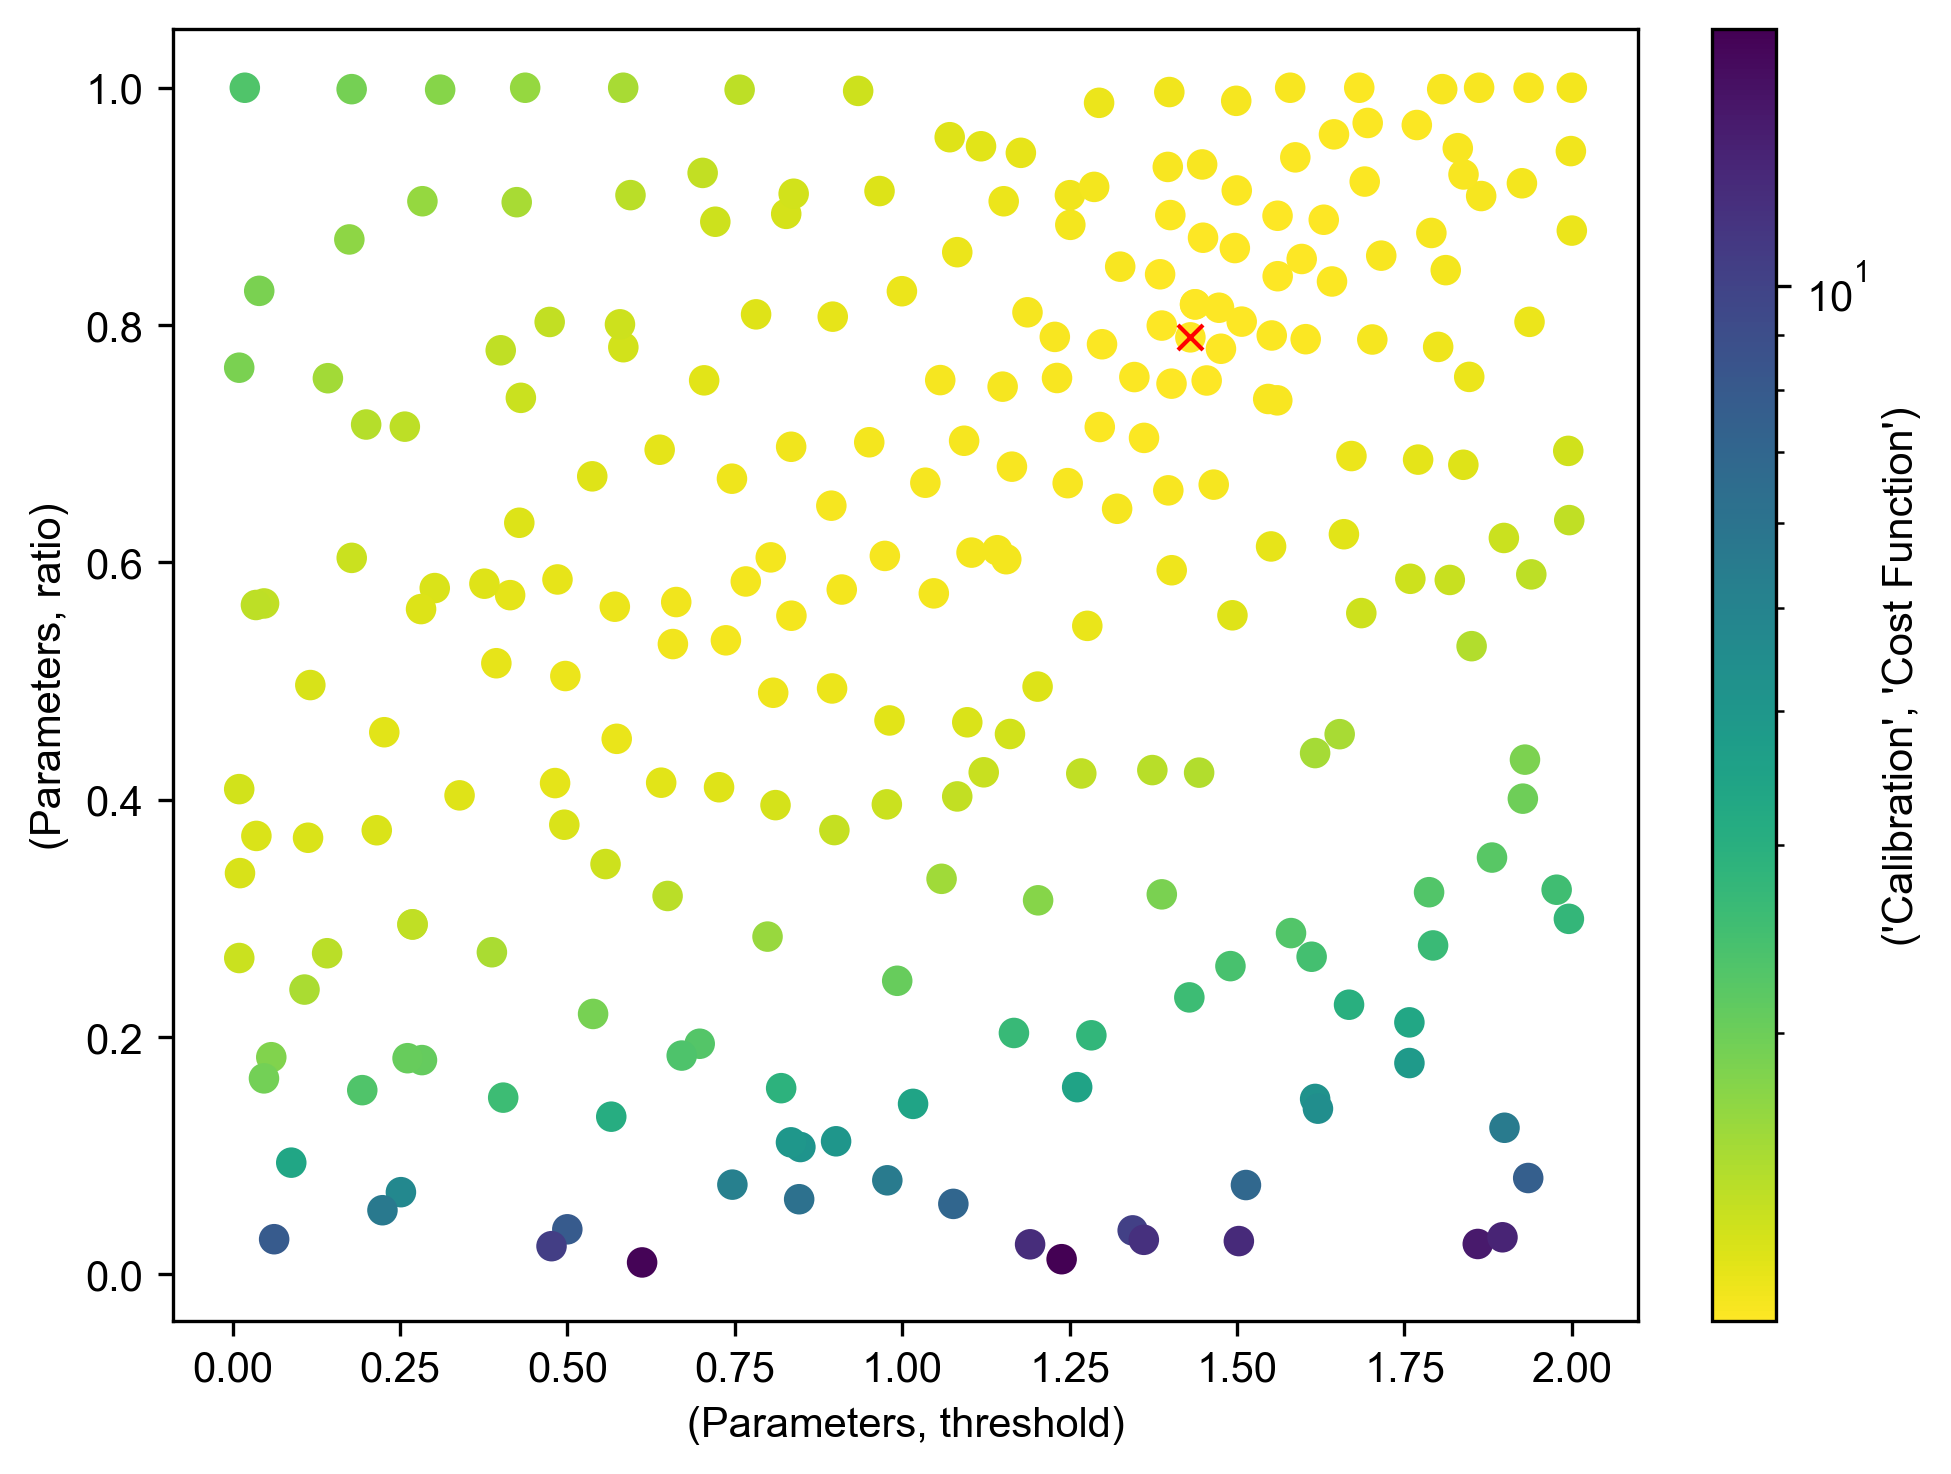

In [29]:
ax = res_flopros.plot_p_space(
    x="threshold",
    y="ratio",
    norm=mcolors.LogNorm(),
)

In [30]:
res_eval_flopros = BayesianOptimizerOutputEvaluator(input_flopros, res_flopros)

(0.0, 1640253.8793085767)

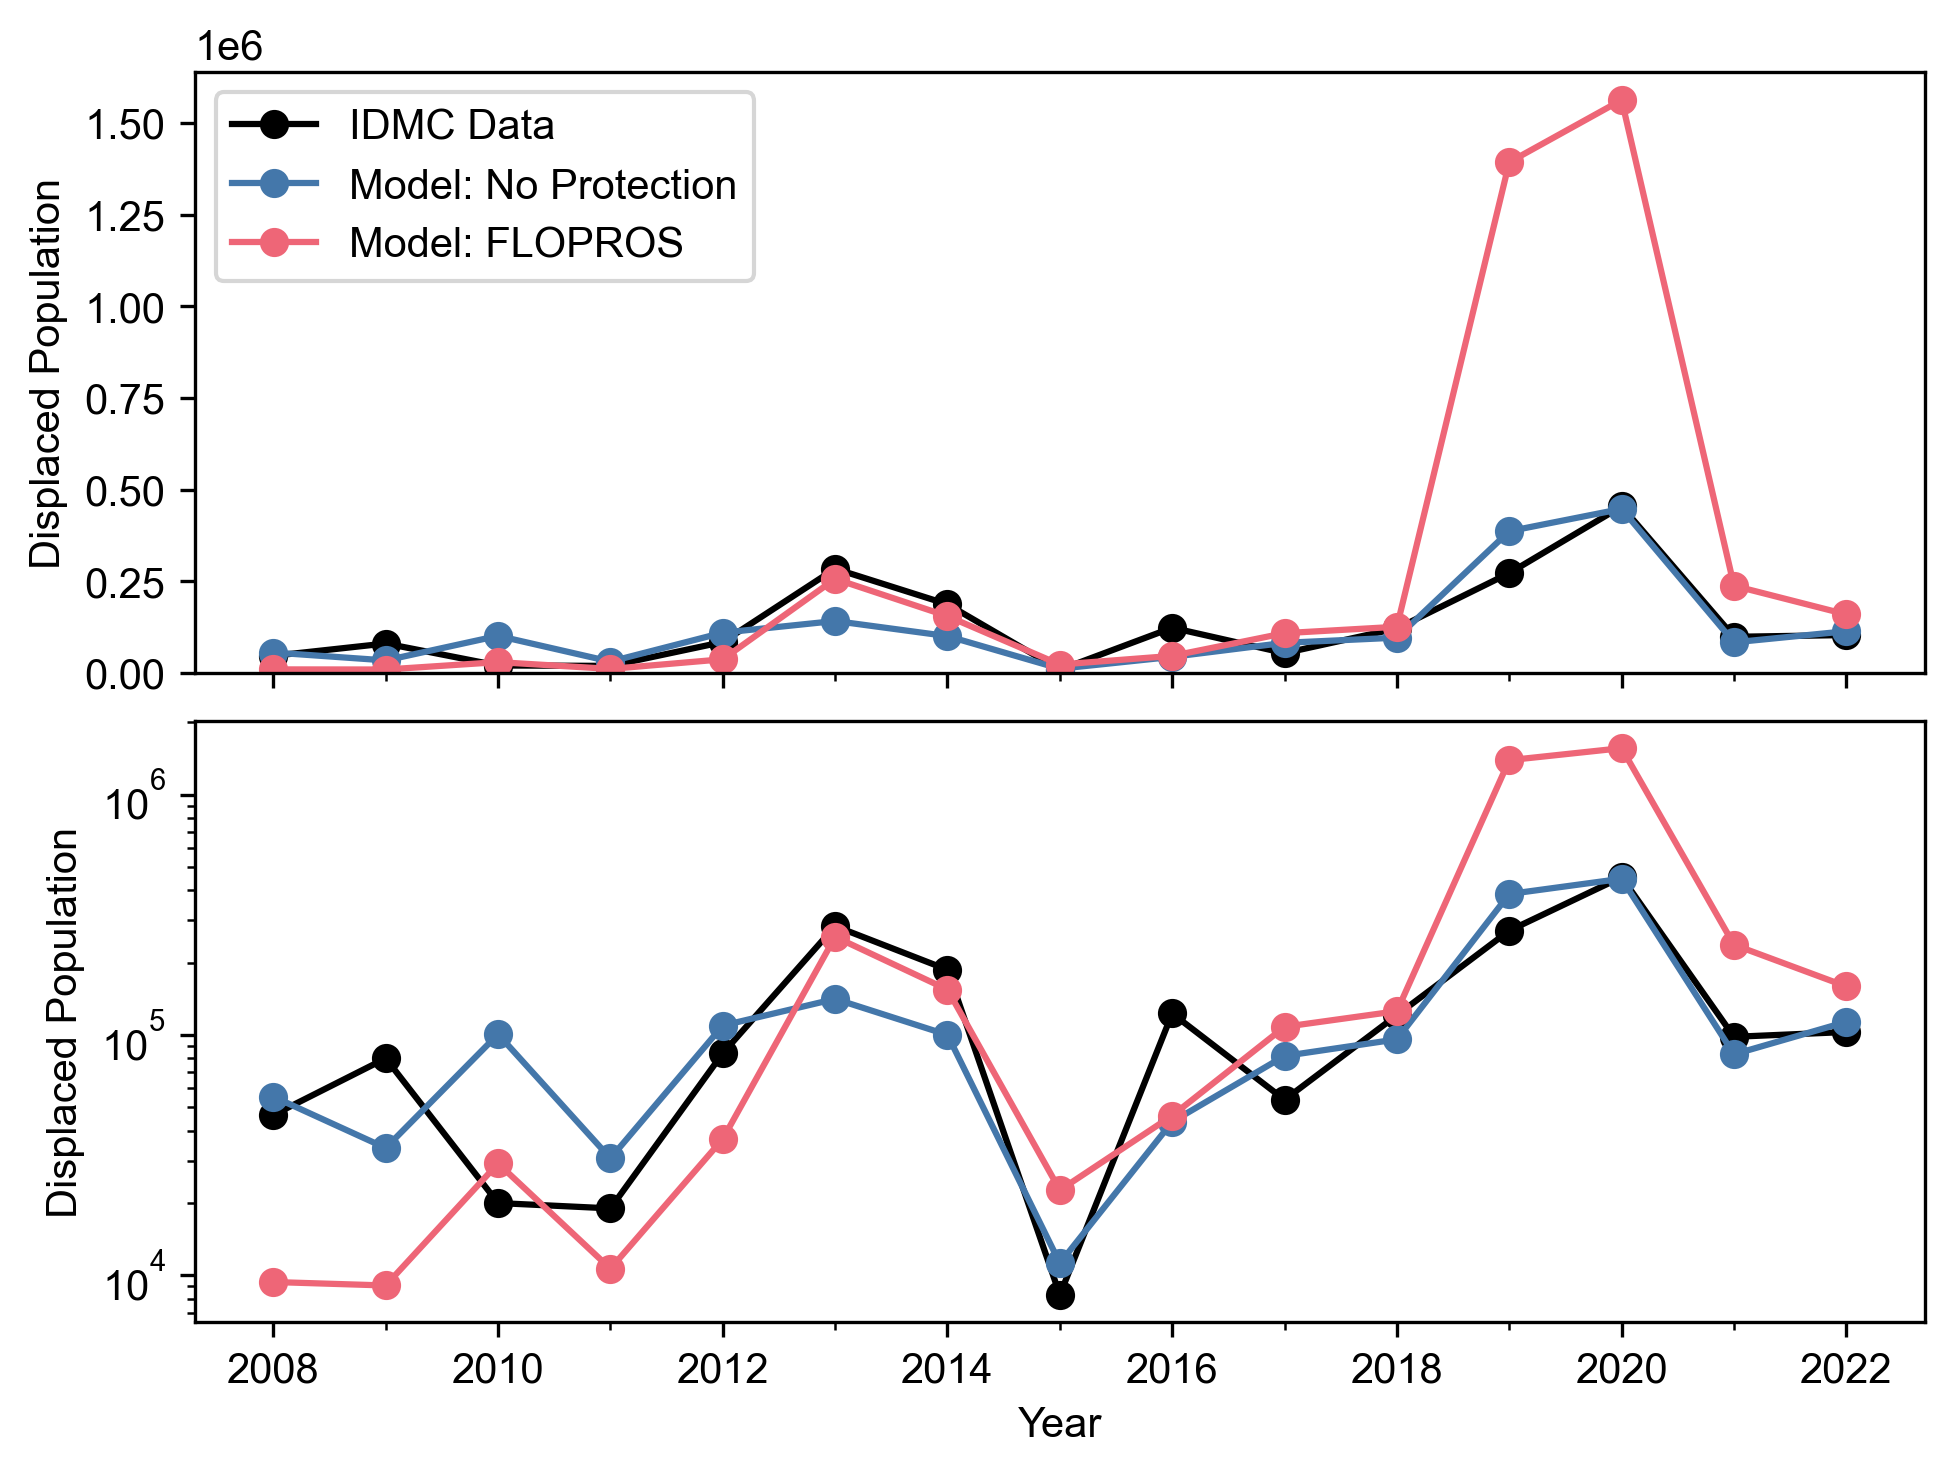

In [39]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cycler import cycler
import tol_colors

rc = {
    "axes.titlesize": "medium",
    "axes.prop_cycle": cycler(color=tol_colors.tol_cset("bright")),
    "figure.dpi": 300,
    "figure.constrained_layout.use": True,
    # "figure.figsize": (FIG_WIDTH_TWO_COL, FIG_HEIGHT),
    "font.family": "Arial",
    "font.size": 10.0,
}
plt.rcParams.update(rc)

_, df_impact = input.impact_to_aligned_df(res_eval.impact)
_, df_impact_florpos = input.impact_to_aligned_df(res_eval_flopros.impact)

fig, axes = plt.subplots(2, 1, sharex=True)

for ax in axes:
    pd.concat(
        [
            data_impacts.copy()
            .rename(columns={"Disaster Internal Displacements": region_id})[729]
            .rename("IDMC Data"),
            df_impact[729].rename("Model: No Protection"),
            df_impact_florpos[729].rename("Model: FLOPROS"),
        ],
        axis=1,
    ).plot.line(
        color={"IDMC Data": "k", "Model: No Protection": "C0", "Model: FLOPROS": "C1"},
        marker="o",
        ax=ax,
        legend=True if ax is axes[0] else False
    )
    ax.set_ylabel("Displaced Population")

# ax.set_ylim(bottom=0, top=350e3)
axes[1].set_xlabel("Year")
axes[1].set_yscale("log")
axes[1].xaxis.set_minor_locator(mticker.FixedLocator(data_impacts.index))
axes[0].set_ylim(bottom=0)

In [40]:
fig.savefig("impacts.pdf")

In [32]:
# Exceedance frequency curve for observed impacts

from climada.engine import Impact
import numpy as np

at_event = data_impacts["Disaster Internal Displacements"].to_numpy()
impact_obs = Impact(
    at_event=at_event,
    frequency=np.ones_like(at_event) / at_event.size,
    event_id=np.arange(at_event.size),
    event_name=np.full_like(at_event, "", dtype=str),
    date=np.ones_like(at_event, dtype=int),
)

Text(0.5, 1.0, '')

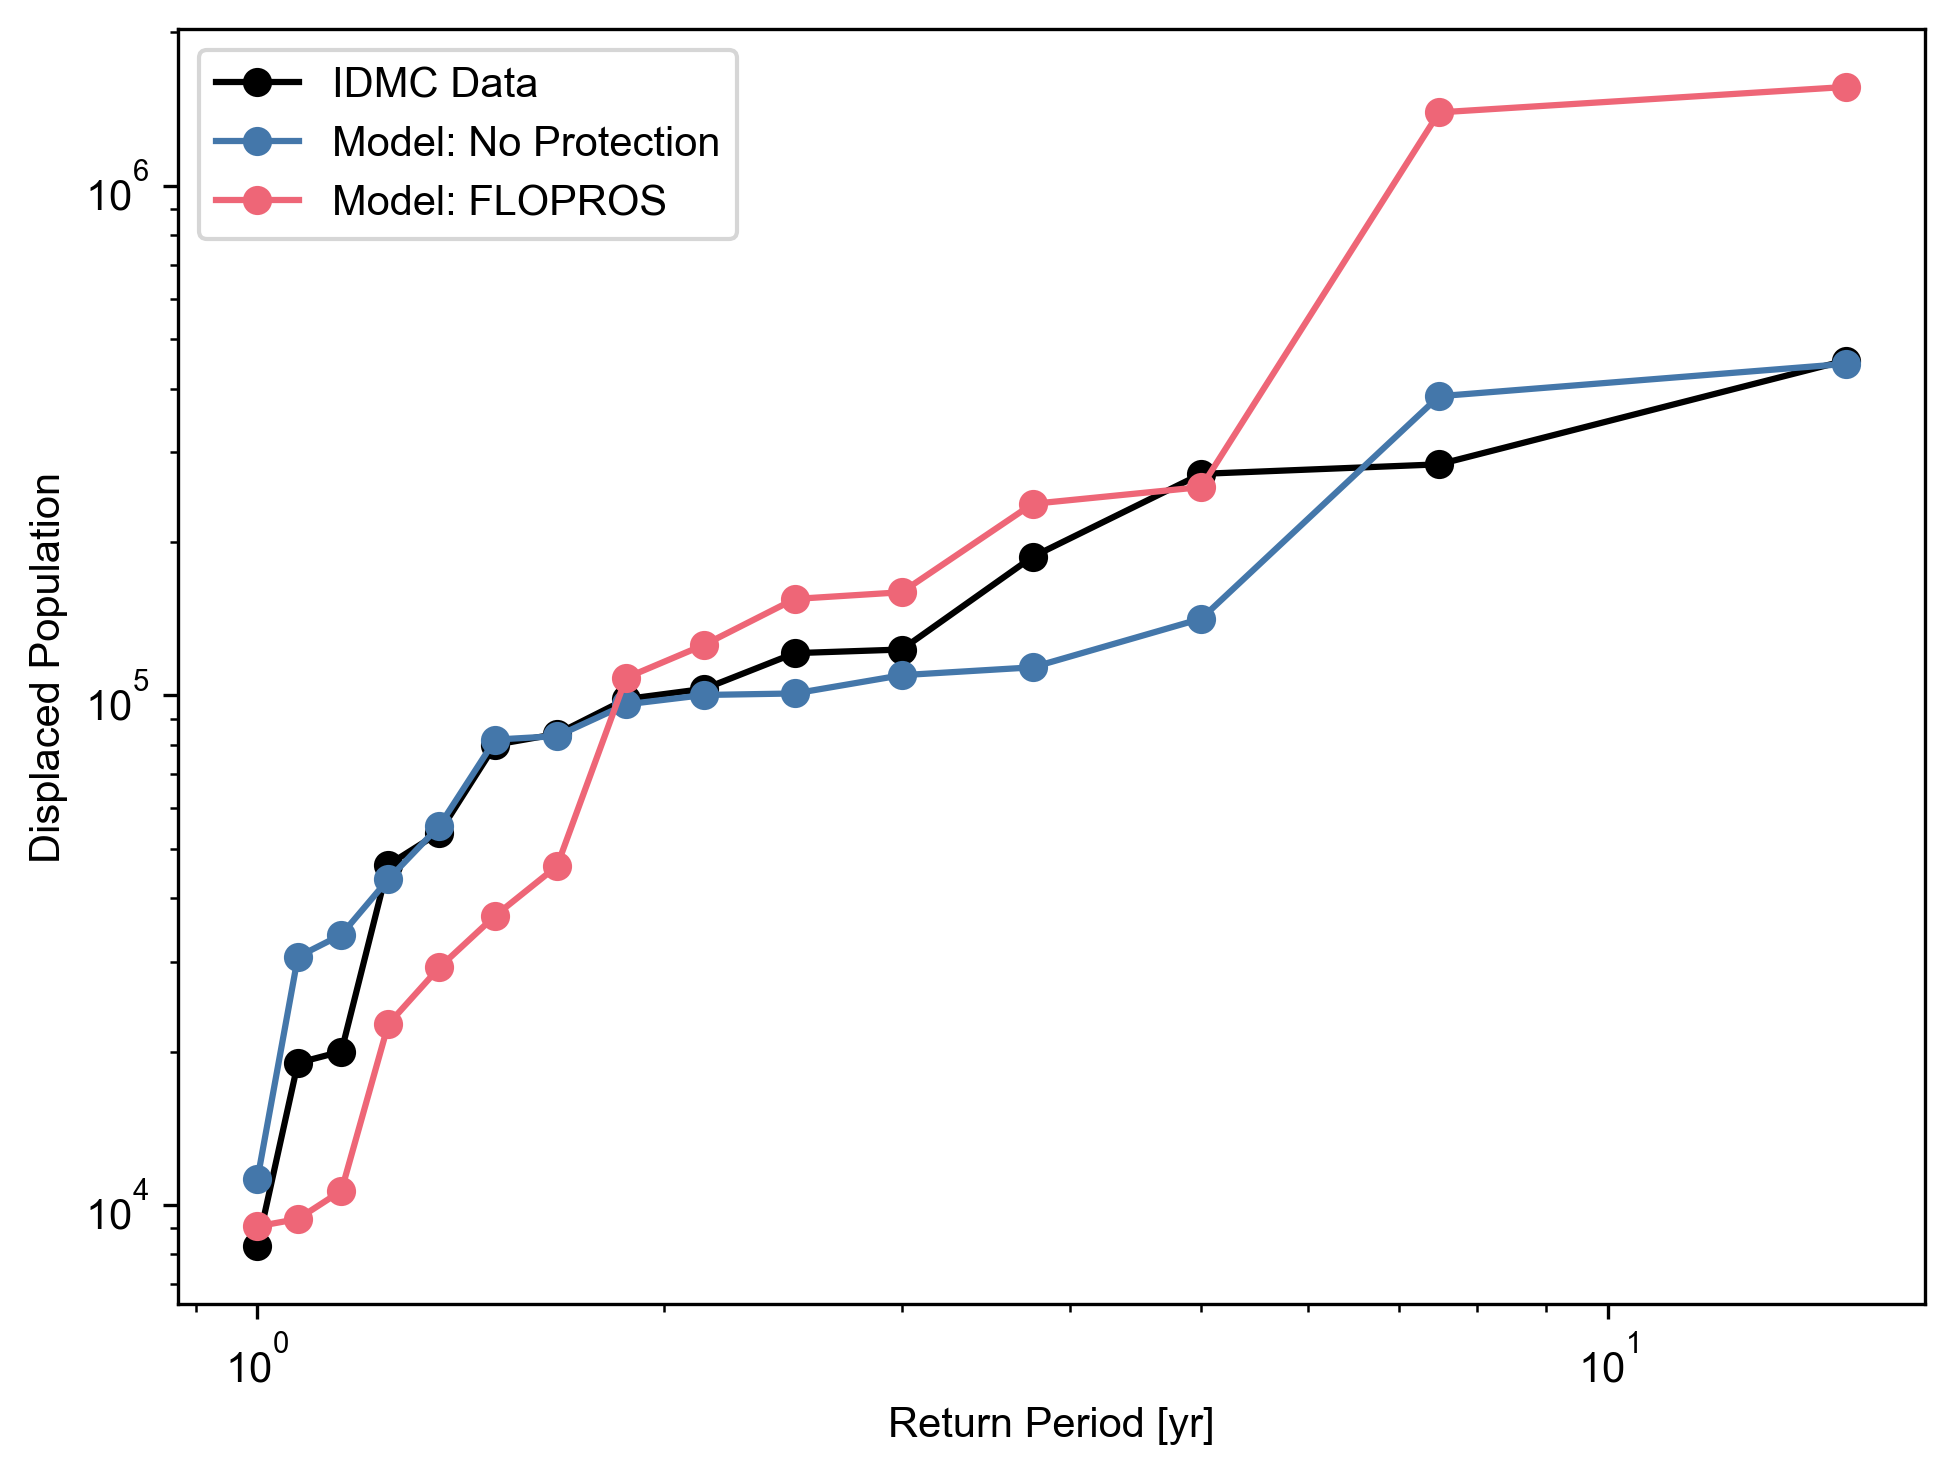

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
impact_obs.calc_freq_curve().plot(axis=ax, marker="o", color="k", label="IDMC Data")
res_eval.impact.calc_freq_curve().plot(
    axis=ax, marker="o", color="C0", label="Model: No Protection"
)
res_eval_flopros.impact.calc_freq_curve().plot(
    axis=ax, marker="o", color="C1", label="Model: FLOPROS"
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Return Period [yr]")
ax.set_ylabel("Displaced Population")
ax.legend()
ax.set_title("")

In [34]:
# Total displacements (for DisplacementMIP?)
pd.concat(
    [
        data_impacts.copy().rename(
            columns={"Disaster Internal Displacements": region_id}
        )[729].rename("Data"),
        df_impact[729].rename("Model"),
        df_impact_florpos[729].rename("Model FLOPROS"),
    ],
    axis=1,
).sum(axis=0)

Data             1.953930e+06
Model            1.834772e+06
Model FLOPROS    4.161353e+06
dtype: float64

In [35]:
res.params

{'ratio': 0.10468650426924575, 'threshold': 0.5283370083893449}

In [36]:
res_flopros.params

{'ratio': 0.789652087642357, 'threshold': 1.4304110863842558}

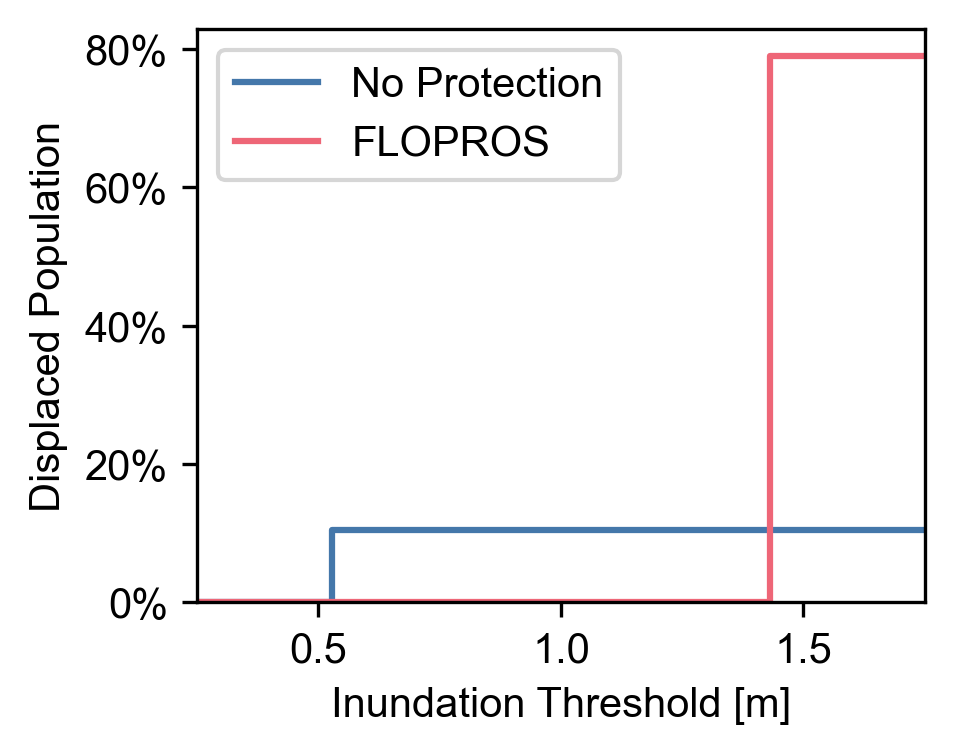

In [37]:
# Plot calibrated impact functions

figsize = np.array(plt.rcParams["figure.figsize"])
fig, ax = plt.subplots(1, 1, figsize=figsize/2)

ax.plot(
    [0, res.params["threshold"], res.params["threshold"], 2],
    [0, 0, res.params["ratio"], res.params["ratio"]],
    label="No Protection"
)
ax.plot(
    [0, res_flopros.params["threshold"], res_flopros.params["threshold"], 2],
    [0, 0, res_flopros.params["ratio"], res_flopros.params["ratio"]],
    label="FLOPROS"
)

ax.set_ylabel("Displaced Population")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
ax.set_xlabel("Inundation Threshold [m]")
ax.set_xlim(left=0.25, right=1.75)
ax.set_ylim(bottom=0)
ax.legend()

In [38]:
fig.savefig("impact-func.pdf")